In [23]:
import pandas as pd
import glob
from tqdm import tqdm
tqdm.pandas()

import stanza
stanza.download('hu')
nlp = stanza.Pipeline('hu')

import networkx as nx
import numpy as np

2020-07-09 14:32:37 INFO: Downloading default packages for language: hu (Hungarian)...
2020-07-09 14:32:38 INFO: File exists: /mnt/volume/jupyter/stanza_resources/hu/default.zip.
2020-07-09 14:32:41 INFO: Finished downloading models and saved to /mnt/volume/jupyter/stanza_resources.
2020-07-09 14:32:41 INFO: Loading these models for language: hu (Hungarian):
| Processor | Package |
-----------------------
| tokenize  | szeged  |
| pos       | szeged  |
| lemma     | szeged  |
| depparse  | szeged  |

2020-07-09 14:32:41 INFO: Use device: cpu
2020-07-09 14:32:41 INFO: Loading: tokenize
2020-07-09 14:32:42 INFO: Loading: pos
2020-07-09 14:32:43 INFO: Loading: lemma
2020-07-09 14:32:43 INFO: Loading: depparse
2020-07-09 14:32:44 INFO: Done loading processors!


In [2]:
def lemmatize(text):
    if type(text) is float: return text
    doc=nlp(text)
    return ' '.join([word.lemma for word in doc.sentences[0].words])

In [3]:
limit=20

In [4]:
resfiles=glob.glob('resultfiles/*_szokereso_result.csv')
dictstrings = ['person_data', 'wikilist','settlement_list','stanza','szotar_2.1']

In [5]:
res={}
for resfile in resfiles:
    df=pd.read_csv(resfile)
    freqdf = pd.concat([df[col]
                       for dictstring in dictstrings
                       for col in df.columns if dictstring in col]
                       ).value_counts(
                       ).rename_axis('unique_entries_not_lemmatized'
                       ).reset_index(name='counts')
    res[resfile]=freqdf

In [6]:
freqdf=res['resultfiles/data_2020-07-06_06:00:32_szokereso_result.csv']

In [7]:
freqdf['lemmatized']=freqdf.truncate(after=limit)['unique_entries_not_lemmatized'].progress_apply(lemmatize)

100%|██████████| 21/21 [00:26<00:00,  1.27s/it]


In [8]:
freqdf_onlylemmatized = freqdf.\
                        groupby(['lemmatized']).\
                        agg({'counts': 'sum'}).\
                        sort_values(by=['counts'],ascending=False).\
                        reset_index()

In [9]:
cooc = pd.DataFrame(index=freqdf_onlylemmatized['lemmatized'], columns=freqdf_onlylemmatized['lemmatized'])

In [10]:
cooc.index.names =   ['row']
cooc.columns.names = ['column']

In [11]:
df=pd.read_csv('resultfiles/data_2020-07-06_06:00:32_szokereso_result.csv')

In [12]:
dictcols = [col for col in df.columns if any([dictstring in col for dictstring in dictstrings])]

In [13]:
for icoocrow, coocrow in enumerate(cooc.index):
    for icooccol, cooccol in enumerate(cooc.columns):
        if icoocrow ==icooccol: print(icoocrow/limit)
        if icoocrow > icooccol:
            count=0
            for index, row in df[[*dictcols]].iterrows():
                if cooccol in list(row) and coocrow in list(row):
                    count+=1
            cooc.loc[coocrow,cooccol]=count

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95


In [ ]:
#!!!RUN ONLY ONCE!!!
cooc=cooc.add(cooc.transpose(),fill_value=0)

In [35]:
G=nx.from_numpy_matrix(cooc.fillna(0).to_numpy())

In [36]:
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]

In [39]:
import matplotlib.pyplot as plt

In [67]:
mapping={index:each for index, each in enumerate(cooc.columns)}

In [68]:
H = nx.relabel_nodes(G, mapping)

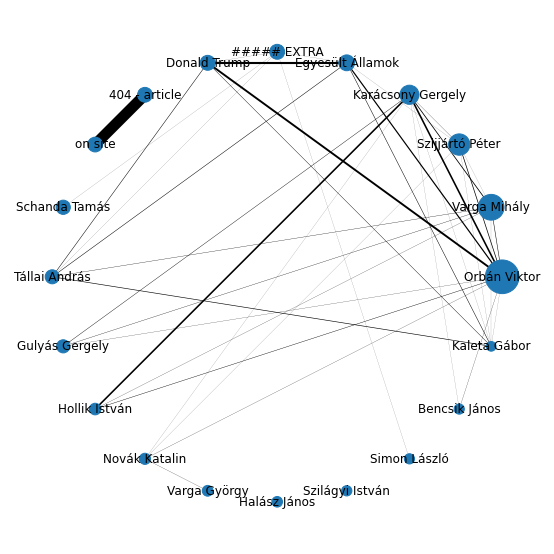

In [93]:
plt.figure(figsize=(7.5,7.5))
wscale=0.1
sscale=2
nx.draw_shell(H,
              with_labels=True,
              width=[weight*wscale for weight in weights],
              node_size=[freqdf_onlylemmatized.set_index('lemmatized').loc[eachperson][0]*sscale
                         for eachperson in H])
plt.margins(0.1,0.1)